In [3]:
# ! pip install sklearn-crfsuite
# ! pip install hyperopt
# ! pip install hyperas
import os
import time
import warnings
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn_crfsuite import CRF, metrics
from IPython.display import display, clear_output

import hyperas
import hyperopt
from hyperas.distributions import uniform
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperas import optim

os.chdir(r'C:\Users\StanvanLoon\OneDrive - Umbrio B.V\Documents\Master Business Analytics\Applied Text Mining\3. Corpus preprocessing and feature extraction')
warnings.filterwarnings('ignore')

# Final Pre-Processing

In [2]:
def generate_input(df, features, show=True):
    
    X, y = [], []
    number_of_sentences = len(df.idx_sent.unique())
    
    for i, sentence_id in enumerate(df.idx_sent.unique()):
        if show: print(f'\rSentence: {i+1}/{number_of_sentences}', end='')
        
        sentence_data = df[df.idx_sent == sentence_id]

        X.append([sentence_data.loc[row, features].to_dict() for row in sentence_data.index])
        y.append(sentence_data['Negation_cue'].values)
    
    return X, y

In [3]:
train_data = pd.read_csv('Data/tmtrain.Preprocessed.csv', index_col=0)
dev_data = pd.read_csv('Data/tmdev.Preprocessed.csv', index_col=0)

In [4]:
train_data.head()

,Token_ID,Token,Lemma,POS,POS_TAG,Dependency_Head,Dependency_Label,idx_sent,Negation_cue,next,prev,trigram,trigram_list,prev_bigram,prev_bigram_list,next_bigram,next_bigram_list,HECT,HECA
0,0,Chapter,chapter,NOUN,NN,5,nmod,0,O,Pad,1,Chapter 1 Mr.,"['Chapter', '1', 'Mr.']",Chapter 1,"['Chapter', '1']",Chapter 1,"['Chapter', '1']",0,0
1,1,1,1,NUM,CD,1,nummod,0,O,Chapter,Mr.,Chapter 1 Mr.,"['Chapter', '1', 'Mr.']",Chapter 1,"['Chapter', '1']",1 Mr.,"['1', 'Mr.']",0,0
2,2,Mr.,Mr.,PROPN,NNP,5,compound,0,O,1,Sherlock,1 Mr. Sherlock,"['1', 'Mr.', 'Sherlock']",1 Mr.,"['1', 'Mr.']",Mr. Sherlock,"['Mr.', 'Sherlock']",0,0
3,3,Sherlock,Sherlock,PROPN,NNP,5,compound,0,O,Mr.,Holmes,Mr. Sherlock Holmes,"['Mr.', 'Sherlock', 'Holmes']",Mr. Sherlock,"['Mr.', 'Sherlock']",Sherlock Holmes,"['Sherlock', 'Holmes']",0,0
4,4,Holmes,Holmes,PROPN,NNP,0,ROOT,0,O,Sherlock,Mr.,Sherlock Holmes Mr.,"['Sherlock', 'Holmes', 'Mr.']",Sherlock Holmes,"['Sherlock', 'Holmes']",Holmes Mr.,"['Holmes', 'Mr.']",0,0


# Feature Selection

In [4]:
all_features = ['Token', 'Lemma', 'POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label',
                'next', 'prev', 'trigram', 'prev_bigram', 'next_bigram', 'HECT', 'HECA']

In [5]:
def feature_ablation(all_features):
    
    best_scores = []
    order_of_removal = []
    features_to_use = all_features.copy()
    train_x, train_y = generate_input(train_data, features_to_use, False)
    dev_x, dev_y = generate_input(dev_data, features_to_use, False)
    
    while len(features_to_use) > 1:
        
        scores = []
        print('\n', features_to_use)

        for feature in features_to_use:
            
            temp_train_x = deepcopy(train_x)
            temp_dev_x = deepcopy(dev_x)
            
            for sentence in temp_train_x:
                for word in sentence:
                    del word[feature]
        
            for sentence in temp_dev_x:
                for word in sentence:
                    del word[feature]            
            
            # Build new classifier
            crf = CRF(algorithm='lbfgs',
                      c1=0.1,
                      c2=0.1,
                      max_iterations=100,
                      all_possible_transitions=True)
            try: crf.fit(temp_train_x, train_y)
            except AttributeError: pass

            # Measure performance
            prediction = crf.predict(temp_dev_x)
            score = metrics.flat_f1_score(dev_y, prediction, average='weighted', labels=list(crf.classes_))
            scores.append(score)
            print(score)

        # Remove worst feature
        best_scores.append(np.max(scores))
        index_worst_feature = np.argmax(scores)
        feature_to_delete = features_to_use[index_worst_feature]
        
        for sentence in train_x:
            for word in sentence:
                del word[feature_to_delete]
        
        for sentence in dev_x:
            for word in sentence:
                del word[feature_to_delete]
        
        # Save progress
        order_of_removal.append(feature_to_delete)
        features_to_use.remove(feature_to_delete)
    
    return order_of_removal, best_scores

In [6]:
order_of_removal, best_scores = feature_ablation(all_features)


 ['Token', 'Lemma', 'POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label', 'next', 'prev', 'trigram', 'prev_bigram', 'next_bigram', 'HECT', 'HECA']
0.9972501448476203
0.9972501448476203
0.9971781438385873
0.9972501448476203
0.9971781438385873
0.9972501448476203
0.9971781438385873
0.9972501448476203
0.9970976414723567
0.9970976414723567
0.9971781438385873
0.9971781438385873
0.9966703372147931

 ['Lemma', 'POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label', 'next', 'prev', 'trigram', 'prev_bigram', 'next_bigram', 'HECT', 'HECA']
0.9972501448476203
0.9972501448476203
0.9972501448476203
0.9971781438385873
0.9972501448476203
0.9971781438385873
0.9972501448476203
0.9970976414723567
0.9970976414723567
0.9971063523377965
0.9970888227590222
0.9966703372147931

 ['POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label', 'next', 'prev', 'trigram', 'prev_bigram', 'next_bigram', 'HECT', 'HECA']
0.9971781438385873
0.9971781438385873
0.9972501448476203
0.9972501448476203
0.9972501448476203
0.99

In [48]:
order_of_addition = ['HECT', 'HECA', 'POS-tag', 'Prev_token', 'Prev_bigram', 'Next_bigram', 'Trigram',
                     'Next_token',  'Dep_label', 'POS', 'Dep_head', 'Lemma', 'Token']
scores = [0.9972501448476203, 0.9972501448476203, 0.9972501448476203, 0.9972501448476203, 0.9972501448476203,
          0.9972501448476203, 0.9972501448476203, 0.9972501448476203, 0.9974901654846495, 0.9972061214913029,
          0.9965187397501329, 0.996258461737477, 0.995758461737477]
order_of_addition.reverse()

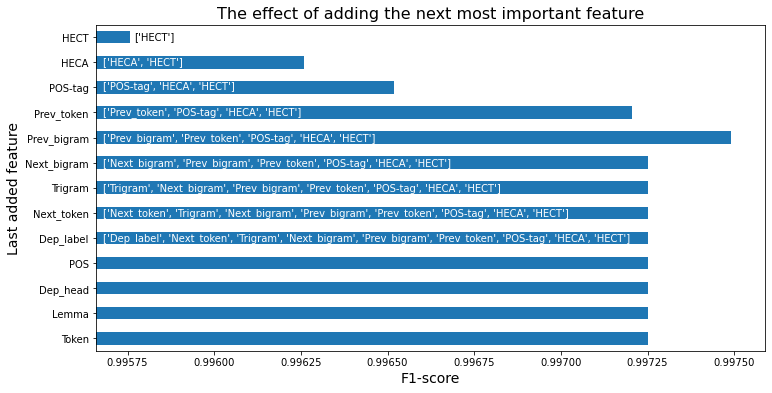

In [51]:
df_bar = pd.DataFrame({'F1-score': scores}, columns=['F1-score'], index=order_of_addition)

ax = df_bar.plot.barh(figsize=(12,6),
                      legend=False,
                      xlim=(np.min(scores)-0.0001, np.max(scores)+0.0001))

ax.text(scores[-1]+0.00001, 12-0.1, order_of_addition[-1:], color='black')
for i in range(2, 10):
    ax.text(0.99568, 13-i-0.1, order_of_addition[-i:], color='white')

plt.title('The effect of adding the next most important feature', size=16)
plt.xlabel('F1-score', size=14)
plt.ylabel('Last added feature', size=14)
plt.savefig('FAS_CRF.pdf', bbox_inches='tight')
plt.show()

In [7]:
features_to_use = ['HECT', 'HECA', 'POS_TAG', 'prev', 'prev_bigram']

print('Train data:')
train_x, train_y = generate_input(train_data, features_to_use)
print('\n\nDevelopment data:')
dev_x, dev_y = generate_input(dev_data, features_to_use)

print(len(train_data), len(train_x), len(train_y))
print(len(dev_data), len(dev_x), len(dev_y))

In [8]:
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=True)
try: crf.fit(train_x, train_y)
except AttributeError: pass

prediction = crf.predict(dev_x)
metrics.flat_f1_score(dev_y, prediction, average='weighted', labels=list(crf.classes_))

0.9974901654846495

# HyperOpt

In [18]:
space = {'c1': hp.uniform('c1', 0.01, 0.99),
         'c2': hp.uniform('c2', 0.01, 0.99)}

def optimizer(space):
    
    crf = CRF(algorithm='lbfgs',
              c1=space['c1'],
              c2=space['c2'],
              max_iterations=100,
              all_possible_transitions=True)

    try: crf.fit(train_x, train_y)
    except AttributeError: pass
    
    prediction = crf.predict(dev_x)
    F1_score = metrics.flat_f1_score(dev_y, prediction, average='weighted', labels=list(crf.classes_))
    
    return {'loss': -F1_score, 'status': STATUS_OK}

CRF_trails = Trials()

CRF_best = fmin(fn=optimizer,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=CRF_trails)
CRF_best

100%|█████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/trial, best loss: -0.9974901654846495]


{'c1': 0.049750683223734174, 'c2': 0.1323605532276545}

# FINAL MODEL

In [8]:
crf = CRF(algorithm='lbfgs',
          c1=0.04975, # CRF_best['c1'],
          c2=0.13236, # CRF_best['c2'],
          max_iterations=100,
          all_possible_transitions=True)

try: crf.fit(train_x, train_y)
except AttributeError: pass

# Results on Development data

In [9]:
prediction = crf.predict(dev_x)
metrics.flat_f1_score(dev_y, prediction, average='weighted', labels=list(crf.classes_))

0.9974901654846495

13567 13567


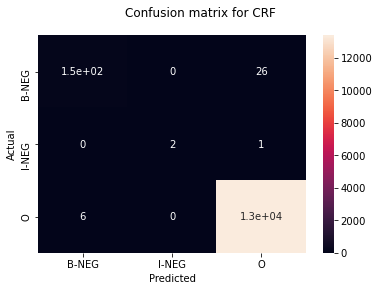

In [12]:
import seaborn as sns

def flatten(array):
    result = []
    for i in array: result.extend(i)
    return result

dev_y_flat = flatten(dev_y)
dev_pred_flat = flatten(prediction)
print(len(dev_y_flat), len(dev_pred_flat))

confusion_matrix = pd.crosstab(pd.DataFrame(dev_y_flat)[0], pd.DataFrame(dev_pred_flat)[0], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.suptitle('Confusion matrix for CRF')
plt.savefig('CM_CRF.pdf')
plt.show()

# Results on Test data

In [39]:
cardboard_data = pd.read_pickle('Data/SEM-2012-SharedTask-CD-SCO-test-cardboard.Preprocessed.pickle')
circle_data = pd.read_pickle('Data/SEM-2012-SharedTask-CD-SCO-test-circle.Preprocessed.pickle')
cardboard_data['prev'] = cardboard_data.Token.shift()
circle_data['prev'] = circle_data.Token.shift()
test_data = pd.concat([cardboard_data, circle_data]).reset_index(drop=True)

In [43]:
features_to_use = ['HECT', 'HECA', 'POS_TAG', 'prev', 'prev_bigram']

test_x, test_y = generate_input(cardboard_data, features_to_use)
test_x2, test_y2 = generate_input(circle_data, features_to_use)

Sentence: 593/593

In [44]:
for i in test_x2: test_x.append(i)
for i in test_y2: test_y.append(i)

In [45]:
pred_test = crf.predict(test_x)
metrics.flat_f1_score(test_y, pred_test, average='weighted', labels=list(crf.classes_))

0.9956732484834067

19216 19216


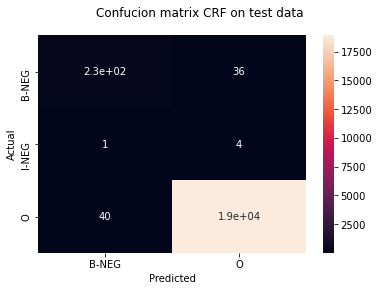

In [46]:
test_y_flat = flatten(test_y)
test_pred_flat = flatten(pred_test)
print(len(test_y_flat), len(test_pred_flat))

confusion_matrix = pd.crosstab(pd.DataFrame(test_y_flat)[0], pd.DataFrame(test_pred_flat)[0], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.suptitle('Confucion matrix CRF on test data')
plt.savefig('CM_CRF_test.pdf')
plt.show()

# Save results

In [47]:
def get_baseline_prediction(row):
    if row.HECT == 1 or row.HECA == 1:
        return 'B-NEG'
    return 'O'

In [48]:
dev_data['pred_base'] = dev_data.apply(get_baseline_prediction, axis=1)
dev_data['pred_CRF'] = dev_pred_flat

test_data['pred_base'] = test_data.apply(get_baseline_prediction, axis=1)
test_data['pred_CRF'] = test_pred_flat
test_data['Negation_cue'] = test_y_flat

columns_to_save = ['Token_ID', 'Token', 'trigram', 'idx_sent', 'HECT', 'HECA', 'Negation_cue', 'pred_CRF']
dev_data = dev_data[columns_to_save]
test_data = test_data[columns_to_save]

In [49]:
dev_data.head()

,Token_ID,Token,trigram,idx_sent,HECT,HECA,Negation_cue,pred_CRF
0,0,1.,1. The Singular,0,0,0,O,O
1,1,The,1. The Singular,0,0,0,O,O
2,2,Singular,The Singular Experience,0,0,0,O,O
3,3,Experience,Singular Experience of,0,0,0,O,O
4,4,of,Experience of Mr.,0,0,0,O,O


In [50]:
test_data.head()

,Token_ID,Token,trigram,idx_sent,HECT,HECA,Negation_cue,pred_CRF
0,0,In,In choosing a,0,0,0,O,O
1,1,choosing,In choosing a,0,0,0,O,O
2,2,a,choosing a few,0,0,0,O,O
3,3,few,a few typical,0,0,0,O,O
4,4,typical,few typical cases,0,0,0,O,O


In [56]:
dev_data.to_csv('CRF_dev_result.csv', index=False)
test_data.to_csv('CRF_test_result.csv', index=False)